In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
%tensorflow_version 1.x
!pip install keras-vggface
!pip install scikit-image
!pip install pydot

TensorFlow 1.x selected.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.python.lib.io import file_io

%matplotlib inline

import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface.vggface import VGGFace
from keras.utils import plot_model
from sklearn.metrics import *
from keras.engine import Model
from keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPool2D, BatchNormalization, Dropout, MaxPooling2D
import skimage
from skimage.transform import rescale, resize

import pydot

Using TensorFlow backend.


In [ ]:
%tensorflow_version 1.x
print(tf.__version__)
print(keras.__version__)

1.15.2
2.3.1


In [ ]:
from keras.optimizers import Adam
from keras.optimizers import SGD

### Load Data

In [ ]:
import pandas as pd
import numpy as np
import csv
from PIL import Image

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/Data_For_Colab/IDS_705_Final_Project/fer2013.csv')

In [ ]:
emotions = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}

In [ ]:
! rm -rf Training test-public test-private
! mkdir Training test-public test-private

In [ ]:
from os import mkdir
for root in ("Training", "test-public", "test-private"):
  for emotion in emotions:
    mkdir(f'{root}/' + f'{emotion} ' + f'{emotions[emotion]}')

In [ ]:
! ls -l Training test-public test-private

test-private:
total 28
drwxr-xr-x 2 root root 4096 Apr 20 13:35 '0 angry'
drwxr-xr-x 2 root root 4096 Apr 20 13:35 '1 disgust'
drwxr-xr-x 2 root root 4096 Apr 20 13:35 '2 fear'
drwxr-xr-x 2 root root 4096 Apr 20 13:35 '3 happy'
drwxr-xr-x 2 root root 4096 Apr 20 13:35 '4 sad'
drwxr-xr-x 2 root root 4096 Apr 20 13:35 '5 surprise'
drwxr-xr-x 2 root root 4096 Apr 20 13:35 '6 neutral'

test-public:
total 28
drwxr-xr-x 2 root root 4096 Apr 20 13:35 '0 angry'
drwxr-xr-x 2 root root 4096 Apr 20 13:35 '1 disgust'
drwxr-xr-x 2 root root 4096 Apr 20 13:35 '2 fear'
drwxr-xr-x 2 root root 4096 Apr 20 13:35 '3 happy'
drwxr-xr-x 2 root root 4096 Apr 20 13:35 '4 sad'
drwxr-xr-x 2 root root 4096 Apr 20 13:35 '5 surprise'
drwxr-xr-x 2 root root 4096 Apr 20 13:35 '6 neutral'

Training:
total 28
drwxr-xr-x 2 root root 4096 Apr 20 13:35 '0 angry'
drwxr-xr-x 2 root root 4096 Apr 20 13:35 '1 disgust'
drwxr-xr-x 2 root root 4096 Apr 20 13:35 '2 fear'
drwxr-xr-x 2 root root 4096 Apr 20 13:35 '3 happy'
drwxr-x

In [ ]:
count = 0
for emotion,image_pixels,usage in zip(df['emotion'], df['pixels'], df['Usage']):
    image_string = image_pixels.split(' ') #pixels are separated by spaces
    image_data = np.asarray(image_string, dtype=np.uint8).reshape(48,48)
    img = Image.fromarray(image_data) #final image\
    count_string = str(count).zfill(6)

    path = ''
    if usage == 'Training':
        path = 'Training/'
    elif usage == 'PublicTest':
        path = 'test-public/'
    elif usage == 'PrivateTest':
        path = 'test-private/'
    else:
        print("Exception!")
    
    # train/2 fear/fear-000001.png
    img.save(path + f'{emotion} ' + f'{emotions[emotion]}/' + f'{emotions[emotion]}-{count_string}.png') 
    count += 1

In [ ]:
! ls -1 Training/* | wc -l
! ls -1 test-private/* | wc -l
! ls -1 test-public/* | wc -l

28722
3602
3602


In [ ]:
%%bash
root='test-private/'
IFS=$(echo -en "\n\b")
(for dir in $(ls -1 "$root")
    do printf "$dir: " && ls -i "$root$dir" | wc -l
 done)

0 angry: 491
1 disgust: 55
2 fear: 528
3 happy: 879
4 sad: 594
5 surprise: 416
6 neutral: 626


In [ ]:
%%bash

(for dir in Training test-private test-public
    #do rm -rf $dir/*.zip
    do pushd $dir && zip -r $dir.zip * && popd
 done)

### Data Generator

In [ ]:
EPOCHS = 50
BS = 128
DROPOUT_RATE = 0.5
FROZEN_LAYER_NUM = 170

ADAM_LEARNING_RATE = 0.001
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

Resize_pixelsize = 197

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_datagen(dataset, aug=False):
    if aug:
        datagen = ImageDataGenerator(
                            rescale=1./255,
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True)
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    return datagen.flow_from_directory(
            dataset,
            target_size=(197, 197),
            color_mode='rgb',
            shuffle = True,
            class_mode='categorical',
            batch_size=BS)

In [ ]:
train_generator  = get_datagen('/content/Training', True)
dev_generator    = get_datagen('/content/test-private')
test_generator  = get_datagen('/content/test-public')

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


### Build Model

In [ ]:
vgg_notop = VGGFace(model='resnet50', include_top=False, input_shape=(197, 197, 3), pooling='avg')
last_layer = vgg_notop.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(4096, activation='relu', name='fc6')(x)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(1024, activation='relu', name='fc7')(x)
x = Dropout(DROPOUT_RATE)(x)

    
batch_norm_indices = [2, 6, 9, 13, 14, 18, 21, 24, 28, 31, 34, 38, 41, 45, 46, 53, 56, 60, 63, 66, 70, 73, 76, 80, 83, 87, 88, 92, 95, 98, 102, 105, 108, 112, 115, 118, 122, 125, 128, 132, 135, 138, 142, 145, 149, 150, 154, 157, 160, 164, 167, 170]
for i in range(FROZEN_LAYER_NUM):
    if i not in batch_norm_indices:
        vgg_notop.layers[i].trainable = False

out = Dense(7, activation='softmax', name='classifier')(x)

model = Model(vgg_notop.input, out)


optim = keras.optimizers.Adam(lr=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


In [ ]:
# add early stopping
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00001,
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

In [ ]:
model.compile(optimizer=optim, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [25]:
history = model.fit_generator(
    generator = train_generator,
    validation_data=dev_generator, 
    steps_per_epoch=28709// BS,
    validation_steps=3509 // BS,
    shuffle=True,
    epochs=100,
    callbacks = [early_stopping],
    use_multiprocessing=True,
)

Epoch 1/100
224/224 [==============================] - 267s 1s/step - loss: 1.8980 - accuracy: 0.4060 - val_loss: 1.8606 - val_accuracy: 0.1693
Epoch 2/100
224/224 [==============================] - 270s 1s/step - loss: 1.1974 - accuracy: 0.5556 - val_loss: 1.8475 - val_accuracy: 0.1788
Epoch 3/100
224/224 [==============================] - 266s 1s/step - loss: 1.1015 - accuracy: 0.5905 - val_loss: 1.4790 - val_accuracy: 0.4647
Epoch 4/100
224/224 [==============================] - 261s 1s/step - loss: 1.0581 - accuracy: 0.6058 - val_loss: 1.0767 - val_accuracy: 0.6199
Epoch 5/100
224/224 [==============================] - 265s 1s/step - loss: 1.0114 - accuracy: 0.6261 - val_loss: 1.0475 - val_accuracy: 0.6538
Epoch 6/100
224/224 [==============================] - 266s 1s/step - loss: 0.9939 - accuracy: 0.6279 - val_loss: 0.8904 - val_accuracy: 0.6553
Epoch 7/100
224/224 [==============================] - 264s 1s/step - loss: 0.9660 - accuracy: 0.6414 - val_loss: 0.9151 - val_accuracy:

In [26]:
#saving the model
import os

os.chdir("//content/gdrive/My Drive/saved_model/")
model.save("model_ResNet.h5")

In [27]:
model.save_weights("model_ResNet_weight.h5")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

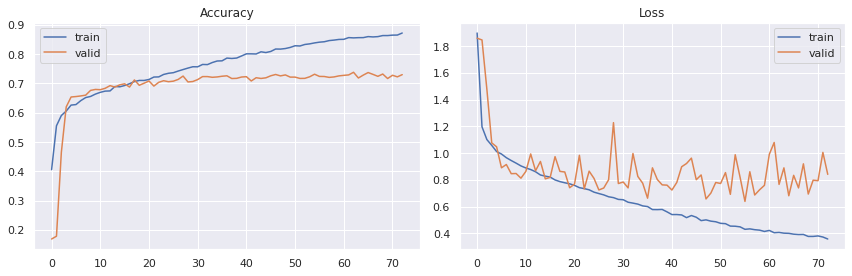

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('epoch_history_resnet.png')
plt.show()

In [33]:
from sklearn.metrics import classification_report

y_test_pred = model.evaluate_generator(test_generator, 3589//128)

print('test loss, test acc:', y_test_pred)

test loss, test acc: [1.0646711587905884, 0.720703125]


In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

y_test_pred = model.predict_classes(X_test)

plt.figure(figsize = (10,10))
cm = confusion_matrix(y_test, y_test_pred)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(emotion))
plt.xticks(tick_marks, emotion, rotation=45)
plt.yticks(tick_marks, emotion)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()